# Boston 주택 가격 예측 모델
Boston 주택 가격 예측 모델에서 사용되는 데이터셋은 보스턴 시의 주택 가격 데이터셋으로, 주택의 여러 요건과 가격 정보가 포함되어 있다.

- 데이터셋 feature
    - CRIM : 자치시별 1인당 범죄율
    - ZN : 25,000 평방피트를 초과하는 거주지역의 비율
    - INDUS : 비소매상업지역이 점유하고 있는 토지의 비율
    - CHAS : 찰스강에 대한 더미변수(강의 경계에 위치한 경우는 1, 아니면 0)
    - NOX : 10ppm 당 농축 일산화질소
    - RM : 주택 1 가구당 평균 방의 개수
    - AGE : 1940년 이전에 건축된 소유주택의 비율
    - DIS : 5개의 보스턴 직업센터까지의 접근성 지수
    - RAD : 방사형 도로까지의 접근성 지수
    - TAX : 10,000 달러당 재산세율
    - PTRATIO : 자치시(town)별 학생/교사 비율
    - B	: $1000(\text{BK} - 0.63)^2$ 여기서Bk는 자치시별 흑인의 비율
    - LSTAT	: 모집단의 하위계층의 비율(%)
    - MEDV : 본인 소유의 주택가격(중앙값)(단위: $1,000)


## 데이터 로드 및 전처리

In [8]:
import seaborn as sns
import matplotlib.pyplot as plt

### boston_housing 데이터셋 로드

In [2]:
from keras.datasets import boston_housing

(train_data, train_labels), (test_data, test_labels) = boston_housing.load_data()

# 데이터셋 크기 확인
print(len(train_data))
print(len(test_data))

65536/57026 [==================================] - 0s 0us/step
404
102


### 표준화 작업 수행

#### 1. 데이터의 각 특성의 평균 빼기

In [4]:
train_data -= train_data.mean(axis=0)

#### 2. 평균을 뺀 입력 데이터에서 표준편차로 나누기
데이터 특성의 중앙 0에 가깝게 만들고, 표준편차가 1이 되게 만든다.

In [5]:
train_data /= train_data.std(axis=0)

#### 3. 테스트 데이터셋도 똑같이 하기

In [6]:
test_data -= test_data.mean(axis=0)

In [7]:
test_data /= test_data.std(axis=0)

## 모델 구성 및 컴파일

### Sequential API
input_shape은 (train_data.shape[1], )으로 구성  
회귀(예측)을 위한 모델이므로 loss를 mse, metrics를 mae로 사용

#### 모델 구성

In [9]:
from tensorflow.keras import models, layers

model = models.Sequential([
    layers.Dense(64, activation='relu', input_shape=(train_data.shape[1],)),
    layers.Dense(64, activation='relu'),
    layers.Dense(1)
])

In [24]:
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense (Dense)                (None, 64)                896       
_________________________________________________________________
dense_1 (Dense)              (None, 64)                4160      
_________________________________________________________________
dense_2 (Dense)              (None, 1)                 65        
Total params: 5,121
Trainable params: 5,121
Non-trainable params: 0
_________________________________________________________________


#### 모델 컴파일

In [10]:
model.compile(optimizer='rmsprop', 
              loss='mse', 
              metrics=['mae'])

### Functional API

In [11]:
from tensorflow.keras import Input, Model

# 입력 텐서
input_tensor = Input(shape=(train_data.shape[1],))

# 레이어 쌓기
x = layers.Dense(64, activation='relu')(input_tensor)
x = layers.Dense(64, activation='relu')(x)


output_tensor = layers.Dense(1)(x)

#### 모델 생성

In [12]:
model_func = Model(inputs=input_tensor, outputs=output_tensor)

#### 모델 컴파일

In [13]:
model_func.compile(optimizer='rmsprop', 
                   loss='mse', 
                   metrics=['mae'])

#### 모델 요약 출력

In [25]:
model_func.summary()

Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 13)]              0         
_________________________________________________________________
dense_3 (Dense)              (None, 64)                896       
_________________________________________________________________
dense_4 (Dense)              (None, 64)                4160      
_________________________________________________________________
dense_5 (Dense)              (None, 1)                 65        
Total params: 5,121
Trainable params: 5,121
Non-trainable params: 0
_________________________________________________________________


### Subclassing API

In [14]:
from tensorflow.keras import Model, layers

class MyModel(Model):
    def __init__(self):
        super(MyModel, self).__init__()
        self.dense1 = layers.Dense(64, activation='relu')
        self.dense2 = layers.Dense(64, activation='relu')
        self.dense3 = layers.Dense(1)  # 회귀 문제이므로 출력층에 활성화 함수를 사용하지 않습니다.

    def call(self, inputs):
        x = self.dense1(inputs)
        x = self.dense2(x)
        return self.dense3(x)

#### 모델 생성

In [15]:
model_subclass = MyModel()

#### 모델 컴파일

In [16]:
model_subclass.compile(optimizer='rmsprop', 
                       loss='mse', 
                       metrics=['mae'])

## 모델 학습

#### Early Stopping
모델 학습 과정에서 검증 데이터셋의 성능이 더 이상 개선되지 않을 때 학습을 조기에 종료하는 기법

In [17]:
from tensorflow.keras.callbacks import EarlyStopping

# Early Stopping 콜백 설정
early_stopping = EarlyStopping(monitor='val_loss',        # 검증 손실을 모니터링
                               patience=20,               # 20 에포크 동안 개선이 없으면 학습을 중단
                               min_delta=0.001,           # 개선으로 간주되는 최소 변화량
                               mode='min',                # 손실이 감소하는 것을 개선으로 간주
                               verbose=1,                 # 얼리 스탑핑의 진행 상황을 출력
                               restore_best_weights=True)  # 가장 좋은 모델의 가중치를 복원

In [19]:
history = model.fit(train_data, train_labels,
                    epochs=200,                       # 최대 에포크 수
                    batch_size=16,                    # 배치 크기
                    validation_split=0.2,             # 20%의 데이터를 검증 데이터로 사용
                    callbacks=[early_stopping],       # 얼리 스탑핑 콜백 추가
                    verbose=1)                        # 학습 과정 출력 생략

Epoch 1/200
21/21 [==============================] - 1s 10ms/step - loss: 519.9833 - mae: 20.8324 - val_loss: 524.4091 - val_mae: 21.0370
Epoch 2/200
21/21 [==============================] - 0s 4ms/step - loss: 400.0181 - mae: 17.9220 - val_loss: 383.6638 - val_mae: 17.6599
Epoch 3/200
21/21 [==============================] - 0s 4ms/step - loss: 267.1541 - mae: 14.1297 - val_loss: 234.2055 - val_mae: 13.1426
Epoch 4/200
21/21 [==============================] - 0s 4ms/step - loss: 143.2942 - mae: 9.7960 - val_loss: 118.9868 - val_mae: 8.4989
Epoch 5/200
21/21 [==============================] - 0s 4ms/step - loss: 76.3670 - mae: 6.6572 - val_loss: 69.8477 - val_mae: 6.3320
Epoch 6/200
21/21 [==============================] - 0s 4ms/step - loss: 50.0860 - mae: 5.2050 - val_loss: 46.5013 - val_mae: 5.0462
Epoch 7/200
21/21 [==============================] - 0s 4ms/step - loss: 35.4005 - mae: 4.2778 - val_loss: 31.0815 - val_mae: 4.2237
Epoch 8/200
21/21 [==============================] - 0

### 시각화

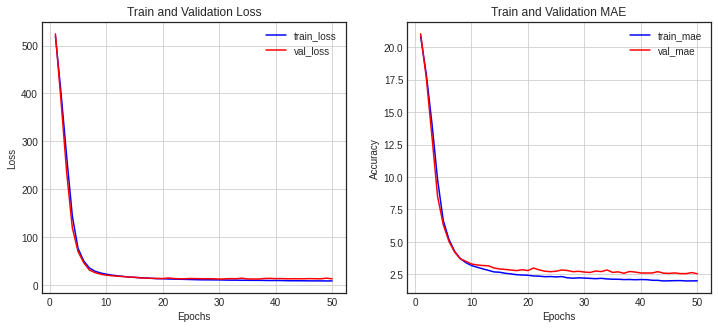

In [22]:
# 모델 학습 히스토리에서 loss, val_loss, mae, val_mae를 차트로 보여준다.
plt.style.use('seaborn-white')

history_dict = history.history

loss = history_dict['loss']
val_loss = history_dict['val_loss']

epochs = range(1, len(loss) + 1)
fig = plt.figure(figsize=(12, 5))

ax1 = fig.add_subplot(1, 2, 1)
ax1.plot(epochs, loss, 'b-', label='train_loss')
ax1.plot(epochs, val_loss, 'r-', label='val_loss')
ax1.set_title('Train and Validation Loss')
ax1.set_xlabel('Epochs')
ax1.set_ylabel('Loss')
ax1.grid()
ax1.legend()

mae = history_dict['mae']
val_mae = history_dict['val_mae']

ax2 = fig.add_subplot(1, 2, 2)
ax2.plot(epochs, mae, 'b-', label='train_mae')
ax2.plot(epochs, val_mae, 'r-', label='val_mae')
ax2.set_title('Train and Validation MAE')
ax2.set_xlabel('Epochs')
ax2.set_ylabel('Accuracy')
ax2.grid()
ax2.legend()

plt.show()

## 모델 평가 및 예측

### 모델 평가

In [20]:
test_loss, test_mae = model.evaluate(test_data, test_labels, verbose=0)

print(f"Test Loss: {test_loss:.3f}")
print(f"Test MAE: {test_mae:.3f}")

Test Loss: 21.300
Test MAE: 3.129


### 주택 가격 예측

In [21]:
predicted_prices = model.predict(test_data)

# 예측된 가격의 처음 5개를 출력
print(predicted_prices[:5])

[[ 6.034957]
 [18.270903]
 [21.875158]
 [28.747677]
 [26.839235]]


### 결과

평가 결과, 테스트 손실(Test Loss)은 21.300이고, 테스트 평균 절대 오차(Test MAE)는 3.129이다.  
이는 모델이 평균적으로 각 주택 가격을 실제 가격과 비교하여 약 $3,129 정도 차이나게 예측했다는 것을 의미한다.   

주택 가격 예측에서 이러한 MAE 수치는 모델이 데이터의 다양한 특성과 주택 가격 사이의 관계를 어느 정도 학습했음을 보여준다.   
그러나 모델 성능을 더 향상시킬 수 있는 여지는 여전히 있으며, 이를 위해서는 모델 구조를 조정하거나,   
더 많은 데이터를 활용하거나, 특성 엔지니어링을 수행하는 등의 방법을 고려할 수 있다.